In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np

from keras import backend as K
from keras.engine import InputSpec, Layer
from keras import initializers, regularizers, constraints
from keras.utils.generic_utils import get_custom_objects
from keras.utils.conv_utils import conv_output_length
#from keras.utils.conv_utils import normalize_data_format
from keras.layers import Conv2D, Conv2DTranspose, SeparableConv2D
from keras.initializers import Constant
K.common.set_image_dim_ordering('tf')

#From:
#https://github.com/mcgibbon/keras/blob/aaf924ca86f819c1d2493b9e7b3dfd4d3d6c729d/keras/layers/discrimination.py

class MinibatchDiscrimination(Layer):
    """Concatenates to each sample information about how different the input
    features for that sample are from features of other samples in the same
    minibatch, as described in Salimans et. al. (2016). Useful for preventing
    GANs from collapsing to a single output. When using this layer, generated
    samples and reference samples should be in separate batches.
    # Example
    ```python
        # apply a convolution 1d of length 3 to a sequence with 10 timesteps,
        # with 64 output filters
        model = Sequential()
        model.add(Convolution1D(64, 3, border_mode='same', input_shape=(10, 32)))
        # now model.output_shape == (None, 10, 64)
        # flatten the output so it can be fed into a minibatch discrimination layer
        model.add(Flatten())
        # now model.output_shape == (None, 640)
        # add the minibatch discrimination layer
        model.add(MinibatchDiscrimination(5, 3))
        # now model.output_shape = (None, 645)
    ```
    # Arguments
        nb_kernels: Number of discrimination kernels to use
            (dimensionality concatenated to output).
        kernel_dim: The dimensionality of the space where closeness of samples
            is calculated.
        init: name of initialization function for the weights of the layer
            (see [initializations](../initializations.md)),
            or alternatively, Theano function to use for weights initialization.
            This parameter is only relevant if you don't pass a `weights` argument.
        weights: list of numpy arrays to set as initial weights.
        W_regularizer: instance of [WeightRegularizer](../regularizers.md)
            (eg. L1 or L2 regularization), applied to the main weights matrix.
        activity_regularizer: instance of [ActivityRegularizer](../regularizers.md),
            applied to the network output.
        W_constraint: instance of the [constraints](../constraints.md) module
            (eg. maxnorm, nonneg), applied to the main weights matrix.
        input_dim: Number of channels/dimensions in the input.
            Either this argument or the keyword argument `input_shape`must be
            provided when using this layer as the first layer in a model.
    # Input shape
        2D tensor with shape: `(samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(samples, input_dim + nb_kernels)`.
    # References
        - [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498)
    """

    def __init__(self, nb_kernels, kernel_dim, init='glorot_uniform', weights=None,
                 W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.init = initializers.get(init)
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        self.input_dim = input_dim

        self.W_regularizer = regularizers.get(W_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),
                                     shape=(None, input_dim))]
        """
        self.W = self.init((self.nb_kernels, input_dim, self.kernel_dim))
        self.trainable_weights = [self.W]
        self.regularizers = []
        if self.W_regularizer:
            self.W_regularizer.set_param(self.W)
            self.regularizers.append(self.W_regularizer)
        if self.activity_regularizer:
            self.activity_regularizer.set_layer(self)
            self.regularizers.append(self.activity_regularizer)
        self.constraints = {}
        if self.W_constraint:
            self.constraints[self.W] = self.W_constraint
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        """
        self.W = self.add_weight(shape=(self.nb_kernels, input_dim, self.kernel_dim),
            initializer=self.init,
            name='mbd_kernel',
            regularizer=self.W_regularizer,
            trainable=True,
            constraint=self.W_constraint)
        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, x, mask=None):
        activation = K.reshape(K.dot(x, self.W), (-1, self.nb_kernels, self.kernel_dim))
        diffs = K.expand_dims(activation, 3) - K.expand_dims(K.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), axis=2)
        minibatch_features = K.sum(K.exp(-abs_diffs), axis=2)
        return K.concatenate([x, minibatch_features], 1)
        #return minibatch_features

    def compute_output_shape(self, input_shape): #renamed from get_output_shape_for (keras 2 support)
        assert input_shape and len(input_shape) == 2
        return input_shape[0], input_shape[1]+self.nb_kernels

    def get_config(self):
        config = {'nb_kernels': self.nb_kernels,
                  'kernel_dim': self.kernel_dim,
                  'init': self.init.__name__,
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'input_dim': self.input_dim}
        base_config = super(MinibatchDiscrimination, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



#https://github.com/WeidiXie/New_Layers-Keras-Tensorflow/blob/master/src/subpix_upsampling.py
#OR 
#BELOW  (https://github.com/farizrahman4u/keras-contrib/blob/a7520c8f520bb5643ff9a62d1b3532fe72ab7283/keras_contrib/layers/convolutional.py)
class SubPixelUpscaling(Layer):
    """ Sub-pixel convolutional upscaling layer based on the paper "Real-Time Single Image
    and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network"
    (https://arxiv.org/abs/1609.05158).
    This layer requires a Convolution2D prior to it, having output filters computed according to
    the formula :
        filters = k * (scale_factor * scale_factor)
        where k = a user defined number of filters (generally larger than 32)
              scale_factor = the upscaling factor (generally 2)
    This layer performs the depth to space operation on the convolution filters, and returns a
    tensor with the size as defined below.
    # Example :
    ```python
        # A standard subpixel upscaling block
        x = Convolution2D(256, 3, 3, padding='same', activation='relu')(...)
        u = SubPixelUpscaling(scale_factor=2)(x)
        [Optional]
        x = Convolution2D(256, 3, 3, padding='same', activation='relu')(u)
    ```
        In practice, it is useful to have a second convolution layer after the
        SubPixelUpscaling layer to speed up the learning process.
        However, if you are stacking multiple SubPixelUpscaling blocks, it may increase
        the number of parameters greatly, so the Convolution layer after SubPixelUpscaling
        layer can be removed.
    # Arguments
        scale_factor: Upscaling factor.
        data_format: Can be None, 'channels_first' or 'channels_last'.
    # Input shape
        4D tensor with shape:
        `(samples, k * (scale_factor * scale_factor) channels, rows, cols)` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows, cols, k * (scale_factor * scale_factor) channels)` if data_format='channels_last'.
    # Output shape
        4D tensor with shape:
        `(samples, k channels, rows * scale_factor, cols * scale_factor))` if data_format='channels_first'
        or 4D tensor with shape:
        `(samples, rows * scale_factor, cols * scale_factor, k channels)` if data_format='channels_last'.
    """

    def __init__(self, scale_factor=2, data_format=None, **kwargs):
        super(SubPixelUpscaling, self).__init__(**kwargs)

        self.scale_factor = scale_factor
        self.data_format = normalize_data_format(data_format)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        y = K.depth_to_space(x, self.scale_factor, self.data_format)
        return y

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_first':
            b, k, r, c = input_shape
            return (b, k // (self.scale_factor ** 2), r * self.scale_factor, c * self.scale_factor)
        else:
            b, r, c, k = input_shape
            return (b, r * self.scale_factor, c * self.scale_factor, k // (self.scale_factor ** 2))

    def get_config(self):
        config = {'scale_factor': self.scale_factor,
                  'data_format': self.data_format}
        base_config = super(SubPixelUpscaling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

#https://github.com/tdrussell/IllustrationGAN/blob/master/custom_ops.py
class CustomLRELU(Layer):
    """
    https://github.com/tdrussell/IllustrationGAN/blob/master/custom_ops.py
    """

    def __init__(self, alpha=0.3, **kwargs):
        super(CustomLRELU, self).__init__(**kwargs)
        self.supports_masking = True
        self.alpha = K.cast_to_floatx(alpha)

    def call(self, inputs):
        return K.maximum(inputs, self.alpha * inputs)

    def get_config(self):
        config = {'alpha': float(self.alpha)}
        base_config = super(CustomLRELU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

def upsample_filt(size):
    factor = (size + 1) // 2
    if size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:size, :size]
    return (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)

def bilinear_upsample_weights(factor, number_of_classes):
    filter_size = factor*2 - factor%2
    weights = np.zeros((filter_size, filter_size, number_of_classes, number_of_classes),
                       dtype=np.float32)
    upsample_kernel = upsample_filt(filter_size)
    for i in range(number_of_classes):
        weights[:, :, i, i] = upsample_kernel
    return weights

#https://github.com/rcmalli/keras-mobilenet/blob/master/keras_mobilenet/depthwise_conv2d.py
def bilinear2x(layer,num_kernels,kernel_size=(5,5),strides=(2,2),factor = 2):
    """
    https://kivantium.net/keras-bilinear
    #NHWC format 
    filter_shape = [kernel_size[0], kernel_size[0], num_inp_channels, num_filters]
    https://www.tensorflow.org/api_docs/python/tf/nn/depthwise_conv2d_native_backprop_input
    """
    #new_layer = Conv2DTranspose(filters = num_kernels, kernel_size = kernel_size, strides = strides, padding='same', kernel_initializer=Constant(bilinear_upsample_weights(factor, num_kernels)),trainable=False)(layer)
    new_layer = Conv2DTranspose(filters = num_kernels, kernel_size = kernel_size, strides = strides, padding='same', kernel_initializer=Constant(bilinear_upsample_weights(factor, num_kernels)))(layer)
    #print('ello')
    return new_layer

In [21]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from sklearn.utils import shuffle
import time
import cv2
import tqdm
from PIL import Image
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten, Dropout
from keras.layers import Input, merge
from keras.layers.pooling import MaxPooling2D
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
#from keras_contrib.layers.convolutional import SubPixelUpscaling
from keras.datasets import mnist
import keras.backend as K
from keras.initializers import RandomNormal
K.common.set_image_dim_ordering('tf')


#import keras.backend as K
#K.set_learning_phase(1)

#we would have BatchNormalization layers on all but the generator output and discriminator input layers
 
np.random.seed(42)


def get_gen_normal(noise_shape):
    noise_shape = noise_shape
    """
    Changing padding = 'same' in the first layer makes a lot fo difference!!!!
    """
    #kernel_init = RandomNormal(mean=0.0, stddev=0.01)
    kernel_init = 'glorot_uniform'
    
    gen_input = Input(shape = noise_shape) #if want to directly use with conv layer next
    #gen_input = Input(shape = [noise_shape]) #if want to use with dense layer next
    
    generator = Conv2DTranspose(filters = 512, kernel_size = (4,4), strides = (1,1), padding = "valid", data_format = "channels_last", kernel_initializer = kernel_init)(gen_input)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
        
    #generator = bilinear2x(generator,256,kernel_size=(4,4))
    #generator = UpSampling2D(size=(2, 2))(generator)
    #generator = SubPixelUpscaling(scale_factor=2)(generator)
    #generator = Conv2D(filters = 256, kernel_size = (4,4), strides = (1,1), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = Conv2DTranspose(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    #generator = bilinear2x(generator,128,kernel_size=(4,4))
    #generator = UpSampling2D(size=(2, 2))(generator)
    #generator = SubPixelUpscaling(scale_factor=2)(generator)
    #generator = Conv2D(filters = 128, kernel_size = (4,4), strides = (1,1), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = Conv2DTranspose(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    #generator = bilinear2x(generator,64,kernel_size=(4,4))
    #generator = UpSampling2D(size=(2, 2))(generator)
    #generator = SubPixelUpscaling(scale_factor=2)(generator)
    #generator = Conv2D(filters = 64, kernel_size = (4,4), strides = (1,1), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)    
    generator = Conv2DTranspose(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    generator = Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = BatchNormalization(momentum = 0.5)(generator)
    generator = LeakyReLU(0.2)(generator)
    
    #generator = bilinear2x(generator,3,kernel_size=(3,3))
    #generator = UpSampling2D(size=(2, 2))(generator)
    #generator = SubPixelUpscaling(scale_factor=2)(generator)
    #generator = Conv2D(filters = 3, kernel_size = (4,4), strides = (1,1), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = Conv2DTranspose(filters = 3, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(generator)
    generator = Activation('tanh')(generator)
        
    gen_opt = Adam(lr=0.00015, beta_1=0.5)
    generator_model = Model(input = gen_input, output = generator)
    generator_model.compile(loss='binary_crossentropy', optimizer=gen_opt, metrics=['accuracy'])
    generator_model.summary()

    return generator_model
    
#------------------------------------------------------------------------------------------

def get_disc_normal(image_shape=(512,512,3)):
    image_shape = image_shape
    
    dropout_prob = 0.4
    
    #kernel_init = RandomNormal(mean=0.0, stddev=0.01)
    kernel_init = 'glorot_uniform'
    
    dis_input = Input(shape = image_shape)
    
    discriminator = Conv2D(filters = 64, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(dis_input)
    discriminator = LeakyReLU(0.2)(discriminator)
    #discriminator = MaxPooling2D(pool_size=(2, 2))(discriminator)
    
    #discriminator = Dropout(dropout_prob)(discriminator)
    discriminator = Conv2D(filters = 128, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    #discriminator = MaxPooling2D(pool_size=(2, 2))(discriminator)
    
    #discriminator = Dropout(dropout_prob)(discriminator)
    discriminator = Conv2D(filters = 256, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    #discriminator = MaxPooling2D(pool_size=(2, 2))(discriminator)
    
    #discriminator = Dropout(dropout_prob)(discriminator)
    discriminator = Conv2D(filters = 512, kernel_size = (4,4), strides = (2,2), padding = "same", data_format = "channels_last", kernel_initializer = kernel_init)(discriminator)
    discriminator = BatchNormalization(momentum = 0.5)(discriminator)
    discriminator = LeakyReLU(0.2)(discriminator)
    #discriminator = MaxPooling2D(pool_size=(2, 2))(discriminator)
    
    discriminator = Flatten()(discriminator)
    
    #discriminator = MinibatchDiscrimination(100,5)(discriminator)
    discriminator = Dense(1)(discriminator)
    discriminator = Activation('sigmoid')(discriminator)
    
    dis_opt = Adam(lr=0.0002, beta_1=0.5)
    discriminator_model = Model(input = dis_input, output = discriminator)
    discriminator_model.compile(loss='binary_crossentropy', optimizer=dis_opt, metrics=['accuracy'])
    discriminator_model.summary()
    return discriminator_model

In [ ]:
import os
import glob
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
from sklearn.utils import shuffle
import time
import cv2
import scipy
import imageio
from PIL import Image
import matplotlib.gridspec as gridspec
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers import Conv2D, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.advanced_activations import LeakyReLU
import matplotlib.pyplot as plt
from keras.models import load_model
import keras.backend as K
from scipy.interpolate import spline
K.common.set_image_dim_ordering('tf')

from collections import deque

np.random.seed(1337)

def norm_img(img):
    img = (img / 127.5) - 1
    return img

def denorm_img(img):
    img = (img + 1) * 127.5
    return img.astype(np.uint8) 


def sample_from_dataset(batch_size, image_shape, data_dir=None, data = None):
    sample_dim = (batch_size,) + image_shape
    sample = np.empty(sample_dim, dtype=np.float32)
    all_data_dirlist = list(glob.glob(data_dir))
    sample_imgs_paths = np.random.choice(all_data_dirlist,batch_size)
    for index,img_filename in enumerate(sample_imgs_paths):
        image = Image.open(img_filename)
        #print(image.size)
        #image.thumbnail(image_shape[:-1], Image.ANTIALIAS) - this maintains aspect ratio ; we dont want that - we need m x m size
        image = image.resize(image_shape[:-1])
        image = image.convert('RGB') #remove transparent ('A') layer
        #print(image.size)
        #print('\n')
        image = np.asarray(image)
        image = norm_img(image)
        sample[index,...] = image
    return sample


def gen_noise(batch_size, noise_shape):
    #input noise to gen seems to be very important!
    return np.random.normal(0, 1, size=(batch_size,)+noise_shape)


def generate_images(generator, save_dir):
    noise = gen_noise(batch_size,noise_shape)
    #using noise produced by np.random.uniform - the generator seems to produce same image for ANY noise - 
    #but those images (even though they are the same) are very close to the actual image - experiment with it later.
    fake_data_X = generator.predict(noise)
    print("Displaying generated images")
    plt.figure(figsize=(18,10))
    gs1 = gridspec.GridSpec(1,1)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(fake_data_X.shape[0],16,replace=False)
    for i in range(16):
        #plt.subplot(4, 4, i+1)
        #ax1 = plt.subplot(gs1[i])
        #ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = fake_data_X[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(save_dir+str(time.time())+"_GENERATEDimage.png",bbox_inches='tight',pad_inches=0)
    plt.show()


def save_img_batch(img_batch,img_save_dir):
    plt.figure(figsize=(18,10))
    gs1 = gridspec.GridSpec(1,1)
    gs1.update(wspace=0, hspace=0)
    rand_indices = np.random.choice(img_batch.shape[0],16,replace=False)
    #print(rand_indices)
    for i in range(16):
        #plt.subplot(4, 4, i+1)
        #ax1 = plt.subplot(gs1[i])
        #ax1.set_aspect('equal')
        rand_index = rand_indices[i]
        image = img_batch[rand_index, :,:,:]
        fig = plt.imshow(denorm_img(image))
        plt.axis('off')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.savefig(img_save_dir,bbox_inches='tight',pad_inches=0)
    plt.show()   



noise_shape = (512,512,100)
num_steps = 10000
batch_size = 64

image_shape = None

img_save_dir = "/home/satyam/gan_for_RF00521_2/"

save_model = False



#image_shape = (96,96,3)
image_shape = (512,512,3)
data_dir =  "/home/satyam/Contact_directory/RF00521/*.png"
#data_dir = "E:\\GAN_Datasets\\curl\\online_ds\\thumb\\*\\*.png"
log_dir = img_save_dir
save_model_dir = img_save_dir

discriminator = get_disc_normal(image_shape)
generator = get_gen_normal(noise_shape)


discriminator.trainable = False

opt = Adam(lr=0.00015, beta_1=0.5) #same as gen
gen_inp = Input(shape=noise_shape)
GAN_inp = generator(gen_inp)
GAN_opt = discriminator(GAN_inp)
gan = Model(input = gen_inp, output = GAN_opt)
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
gan.summary()


avg_disc_fake_loss = deque([0], maxlen=250)     
avg_disc_real_loss = deque([0], maxlen=250)
avg_GAN_loss = deque([0], maxlen=250)



for step in range(num_steps): 
    tot_step = step
    print("Begin step: ", tot_step)
    step_begin_time = time.time() 
    
    real_data_X = sample_from_dataset(batch_size, image_shape, data_dir = data_dir)

    noise = gen_noise(batch_size,noise_shape)
    
    fake_data_X = generator.predict(noise)
    
    if (tot_step % 10) == 0:
        step_num = str(tot_step).zfill(4)
        save_img_batch(fake_data_X,img_save_dir+step_num+"_image.png")

        
    data_X = np.concatenate([real_data_X,fake_data_X])
    
    real_data_Y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
    
    fake_data_Y = np.random.random_sample(batch_size)*0.2
    
     
    data_Y = np.concatenate((real_data_Y,fake_data_Y))
    
        
    discriminator.trainable = True
    generator.trainable = False
    
    dis_metrics_real = discriminator.train_on_batch(real_data_X,real_data_Y)   #training seperately on real
    dis_metrics_fake = discriminator.train_on_batch(fake_data_X,fake_data_Y)   #training seperately on fake
    
    print("Disc: real loss: %f fake loss: %f" % (dis_metrics_real[0], dis_metrics_fake[0]))
    
    
    avg_disc_fake_loss.append(dis_metrics_fake[0])
    avg_disc_real_loss.append(dis_metrics_real[0])
    
    generator.trainable = True

    GAN_X = gen_noise(batch_size,noise_shape)

    GAN_Y = real_data_Y
    
    discriminator.trainable = False
    
    gan_metrics = gan.train_on_batch(GAN_X,GAN_Y)
    print("GAN loss: %f" % (gan_metrics[0]))
    
    text_file = open(log_dir+"\\training_log.txt", "a")
    text_file.write("Step: %d Disc: real loss: %f fake loss: %f GAN loss: %f\n" % (tot_step, dis_metrics_real[0], dis_metrics_fake[0],gan_metrics[0]))
    text_file.close()
    avg_GAN_loss.append(gan_metrics[0])
    
        
    end_time = time.time()
    diff_time = int(end_time - step_begin_time)
    print("Step %d completed. Time took: %s secs." % (tot_step, diff_time))
    
    if ((tot_step+1) % 500) == 0:
        print("-----------------------------------------------------------------")
        print("Average Disc_fake loss: %f" % (np.mean(avg_disc_fake_loss)))    
        print("Average Disc_real loss: %f" % (np.mean(avg_disc_real_loss)))    
        print("Average GAN loss: %f" % (np.mean(avg_GAN_loss)))
        print("-----------------------------------------------------------------")
        discriminator.trainable = True
        generator.trainable = True
        generator.save(save_model_dir+str(tot_step)+"_GENERATOR_weights_and_arch.hdf5")
        discriminator.save(save_model_dir+str(tot_step)+"_DISCRIMINATOR_weights_and_arch.hdf5")



#generator = load_model(save_model_dir+'9999_GENERATOR_weights_and_arch.hdf5')

#generate final sample images
for i in range(10):
    generate_images(generator, img_save_dir)


"""
#Display Training images sample
save_img_batch(sample_from_dataset(batch_size, image_shape, data_dir = data_dir),img_save_dir+"_12TRAINimage.png")
"""

#Generating GIF from PNG
images = []
all_data_dirlist = list(glob.glob(img_save_dir+"*_image.png"))
for filename in all_data_dirlist:
    img_num = filename.split('\\')[-1][0:-10]
    if (int(img_num) % 100) == 0:
        images.append(imageio.imread(filename))
imageio.mimsave(img_save_dir+'movie.gif', images) 
    
"""
Alternate way to convert PNG to GIF (ImageMagick):
    >convert -delay 10 -loop 0 *_image.png animated.gif
"""

/home/satyam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 256, 256, 64)      3136      
_________________________________________________________________
leaky_re_lu_118 (LeakyReLU)  (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 128, 128, 128)     131200    
_________________________________________________________________
batch_normalization_105 (Bat (None, 128, 128, 128)     512       
_________________________________________________________________
leaky_re_lu_119 (LeakyReLU)  (None, 128, 128, 128)     0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 64, 64, 256)       524544    
__________

/home/satyam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 512, 512, 100)     0         
_________________________________________________________________
conv2d_transpose_66 (Conv2DT (None, 515, 515, 512)     819712    
_________________________________________________________________
batch_normalization_108 (Bat (None, 515, 515, 512)     2048      
_________________________________________________________________
leaky_re_lu_122 (LeakyReLU)  (None, 515, 515, 512)     0         
_________________________________________________________________
conv2d_transpose_67 (Conv2DT (None, 1030, 1030, 256)   2097408   
_________________________________________________________________
batch_normalization_109 (Bat (None, 1030, 1030, 256)   1024      
_________________________________________________________________
leaky_re_lu_123 (LeakyReLU)  (None, 1030, 1030, 256)   0         
__________

/home/satyam/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:143: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("mo...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 512, 512, 100)     0         
_________________________________________________________________
model_41 (Model)             (None, 8240, 8240, 3)     3616771   
_________________________________________________________________
model_40 (Model)             (None, 1)                 3284417   
Total params: 6,901,188
Trainable params: 3,614,723
Non-trainable params: 3,286,465
_________________________________________________________________
Begin step:  0


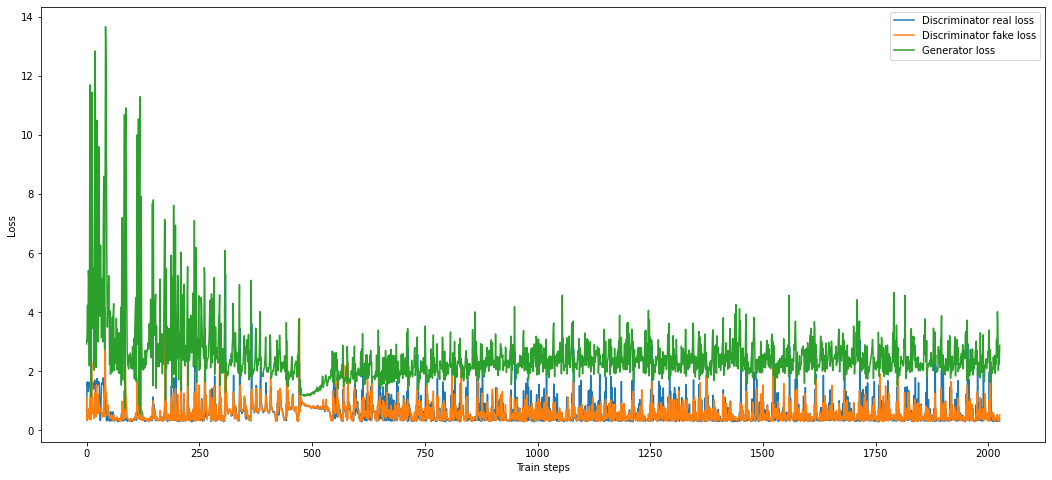

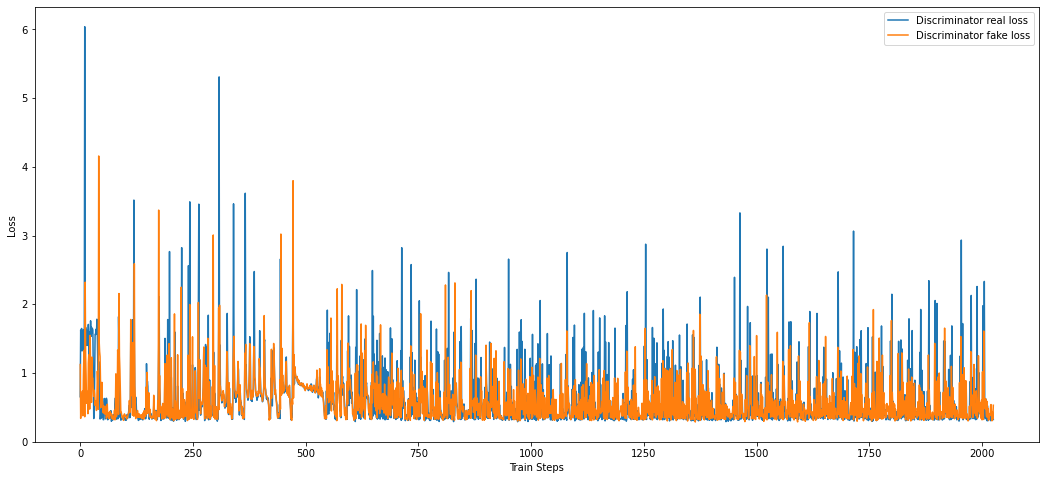

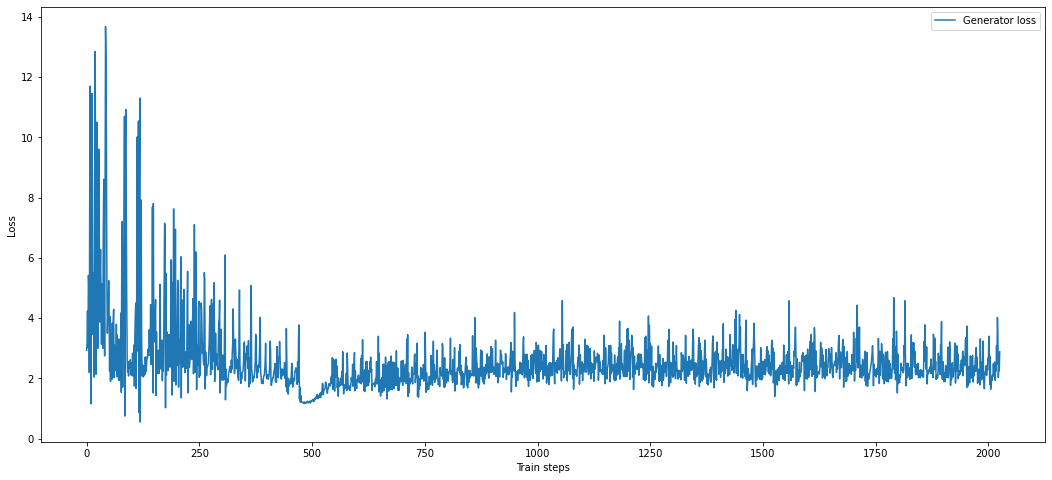

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import spline

#Plotting loss
with open(log_dir+"training_log.txt") as f:
    log_data = f.readlines()
    

train_steps = []
disc_real_loss = []
disc_fake_loss = []
GAN_loss = []
for log in log_data:
    train_steps.append(int(log.split(' ')[1]))
    disc_real_loss.append(float(log.split(' ')[5]))
    disc_fake_loss.append(float(log.split(' ')[8]))
    GAN_loss.append(float(log.split(' ')[11][0:-1]))


#takes too long in my comp; didn't use
# x_smooth = np.linspace(np.array(train_steps).min(), np.array(train_steps).max(), len(train_steps)/10)
# y_smooth = spline(train_steps, disc_real_loss, x_smooth)
# plt.plot(x_smooth,y_smooth,label="Discriminator real loss")


#all 3 in one plot
plt.figure(figsize=(18,8))
plt.plot(train_steps,disc_real_loss,label="Discriminator real loss")
plt.plot(train_steps,disc_fake_loss,label="Discriminator fake loss")
plt.plot(train_steps,GAN_loss,label="Generator loss")
plt.xlabel('Train steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


#real vs fake loss plot
plt.figure(figsize=(18,8))
plt.plot(train_steps, disc_real_loss, '-', label="Discriminator real loss")
plt.plot(train_steps, disc_fake_loss, '-', label="Discriminator fake loss")
plt.legend()
plt.xlabel("Train Steps")
plt.ylabel("Loss")
plt.show()

#gen loss plot
plt.figure(figsize=(18,8))
plt.plot(train_steps, GAN_loss, '-', label="Generator loss")
plt.xlabel("Train steps")
plt.ylabel("Loss")
plt.legend()
plt.show()